In [45]:
# !pip install spacy

In [46]:
# !spacy download en_core_web_md

In [47]:
# !pip install sklearn_crfsuite

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import metrics

import spacy
import en_core_web_md
from spacy.tokens import Doc
nlp = en_core_web_md.load()
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./TrainNER.csv', sep=';', encoding = "ISO-8859-1")


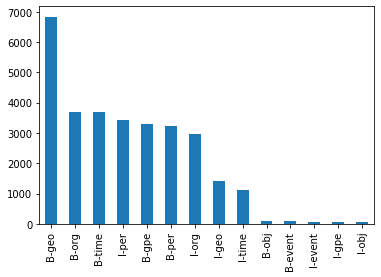

In [23]:
plt.close('all')
df["Tag"].value_counts()[1:].plot(kind='bar')

In [3]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,President,NNP,B-per
1,NaN,Karzai,NNP,I-per
2,NaN,thanked,VBD,O
3,NaN,his,PRP$,O
4,NaN,allies,NNS,O


In [50]:
df.describe()

,Sentence #,Word,POS,Tag
count,9000,196645,196645,196645
unique,9000,15323,41,15
top,Sentence: 5424,the,NN,O
freq,1,9839,27417,166610


In [24]:
df = df.fillna(method='ffill')

In [25]:
classes = np.unique(df.Tag.values).tolist()
classes.pop()
print (classes)

['B-event', 'B-geo', 'B-gpe', 'B-obj', 'B-org', 'B-per', 'B-time', 'I-event', 'I-geo', 'I-gpe', 'I-obj', 'I-org', 'I-per', 'I-time']


In [26]:
def toListTrain(dataset):
    return [(a[0], a[1]) for a in zip(dataset['Word'].values.tolist(), dataset['Tag'].values.tolist())]

def toTuplesTrain(dataset):
    return [a for a in dataset.groupby('Sentence #', sort=False).apply(toListTrain)]

def toList(dataset):
    return [(a,) for a in dataset['Word'].values.tolist()]

def toTuples(dataset):
    return [a for a in dataset.groupby('Sentences', sort=False).apply(toList)]

In [27]:
def sentencesToFeatures(__sentences):
    textTokenizedMap = {' '.join([x[0] for x in s]): [x[0] for x in s] for s in __sentences}
    # use custom tokenizer, because its already tokenized
    def custom_tokenizer(text):
        if text in textTokenizedMap:
            return Doc(nlp.vocab, textTokenizedMap[text])
        else:
            raise ValueError('No tokenization available for input.')

    nlp.tokenizer = custom_tokenizer
    return [ [ getFeatures(X) for X in nlp(' '.join([x[0] for x in s]))] for s in __sentences ]

def getFeatures(token):
    i = token.i
    sentence = token.doc
    isStart = i == 0
    isEnd = i == len(sentence)-1
    token1 = sentence[i - 1] if not isStart else None
    token2 = sentence[i + 1] if not isEnd else None
    features = (
        'word.lower_=' + token.lower_,
        'word.ent_type=' + token.ent_type_,
        'word.ent_iob=' + token.ent_iob_,
        'word.tag_=' + token.tag_,
        'word.pos_=' + token.pos_,
        'word.dep_=' + token.dep_,
        'word.is_alpha=%s' % token.is_alpha,
        'word.like_num=%s' % token.like_num,
        'word.is_stop=%s' % token.is_stop,
        'word.lemma_=%s' % token.lemma_,
        'word.is_digit=%s' % token.is_digit,
        'word.is_lower=%s' % token.is_lower,
        'word.is_title=%s' % token.is_title,
        'word.is_currency=%s' % token.is_currency,
        'word.like_num=%s' % token.like_num,
        '-1:word.lower=' + token1.lower_ if token1 is not None else 'EOF',
        '-1:word.istitle=%s' % token1.is_title if token1 is not None else 'EOF',
        '-1:word.tag=' + token1.tag_ if token1 is not None else 'EOF',
        '+1:word.lower=' + token2.lower_ if token2 is not None else 'EOF',
        '+1:word.istitle=%s' % token2.is_title if token2 is not None else 'EOF',
        '+1:word.tag=' + token2.tag_ if token2 is not None else 'EOF',
        'PLACE=' + 'BOS' if isStart else 'EOS' if isEnd else 'IN',
    )
                
    return features

def sent2labels(sent):
    return [label for token, label in sent]

In [28]:
sentences = toTuplesTrain(df)
X = sentencesToFeatures(sentences)
y = [sent2labels(s) for s in sentences]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
# X

In [29]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.15,
    max_iterations=200,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

C:\Users\horb3nc3\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.5, c2=0.15, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=200,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [30]:
# # Conditional Random Fields
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels = classes))

              precision    recall  f1-score   support

     B-event       0.62      0.38      0.48        26
       B-geo       0.81      0.87      0.84      2200
       B-gpe       0.94      0.87      0.90      1078
       B-obj       0.50      0.05      0.09        43
       B-org       0.76      0.67      0.71      1182
       B-per       0.82      0.82      0.82      1048
      B-time       0.90      0.84      0.87      1198
     I-event       0.33      0.21      0.26        19
       I-geo       0.79      0.73      0.76       480
       I-gpe       1.00      0.28      0.43        18
       I-obj       0.00      0.00      0.00        26
       I-org       0.74      0.74      0.74       950
       I-per       0.84      0.88      0.86      1166
      I-time       0.79      0.68      0.73       402

   micro avg       0.83      0.80      0.81      9836
   macro avg       0.70      0.57      0.61      9836
weighted avg       0.82      0.80      0.81      9836



In [32]:
!pip install eli5
import eli5
eli5.show_weights(crf, top=10)

C:\Users\horb3nc3\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\horb3nc3\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\horb3nc3\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parame

From \ To,O,B-event,I-event,B-geo,I-geo,B-gpe,I-gpe,B-obj,I-obj,B-org,I-org,B-per,I-per,B-time,I-time
O,1.903,0.021,-2.505,0.447,-5.536,0.31,-2.021,0.141,-2.424,0.527,-4.998,1.017,-4.124,0.544,-4.501
B-event,-0.0,0.0,6.695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
I-event,0.0,-0.05,5.449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-geo,0.181,0.0,-0.014,-1.755,5.944,-0.461,-0.783,0.0,0.0,-0.224,-1.635,-0.799,-1.618,1.472,-0.552
I-geo,0.02,0.0,0.0,-0.319,5.47,0.0,0.0,0.919,0.0,0.0,-0.278,-0.111,-0.058,1.799,0.0
B-gpe,0.408,0.0,-0.059,0.778,-0.666,-3.103,3.74,0.0,0.0,1.904,-1.415,0.733,-1.454,-0.648,-0.527
I-gpe,-0.308,0.0,0.0,0.0,0.0,0.0,4.828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-obj,-0.402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.285,0.195,0.0,-0.282,0.0,0.0,0.0
I-obj,-0.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.573,0.0,0.0,0.0,0.0,0.0,0.0
B-org,-0.189,0.0,-0.194,0.037,-1.303,0.216,-0.124,1.447,-0.254,-2.411,5.089,0.129,-2.236,-0.074,-0.504


In [33]:
eli5.show_weights(crf, top=10, feature_re='^word\.is',
                  horizontal_layout=False, show=['targets'])

C:\Users\horb3nc3\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [58]:
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

In [59]:
# crf3 = sklearn_crfsuite.CRF(
#     algorithm='lbfgs',
#     max_iterations=100,
#     all_possible_transitions=True
# )
# params_space = {
#     'c1': scipy.stats.expon(scale=0.5),
#     'c2': scipy.stats.expon(scale=0.05),
# }

# # use the same metric for evaluation
# f1_scorer = make_scorer(metrics.flat_f1_score,
#                         average='weighted', labels=classes)

# # search
# rs = RandomizedSearchCV(crf3, params_space,
#                         cv=3,
#                         verbose=3,
#                         n_jobs=-1,
#                         n_iter=50,
#                         scoring=f1_scorer)
# rs.fit(X_train, y_train)

In [60]:
# print('Best parameters:', rs.best_params_)
# print('Best CV score:', rs.best_score_)
# print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [61]:
# sorted_labels = sorted(
#     classes,
#     key=lambda name: (name[1:], name[0]))

In [62]:
# crf3 = rs.best_estimator_
# y_pred = crf3.predict(X_test)
# print(metrics.flat_classification_report(
#     y_test, y_pred, labels=sorted_labels, digits=3))

In [63]:
flatten = lambda t: [item for sublist in t for item in sublist]

In [66]:
test_raw_df = pd.read_csv('./Test1NER.csv', sep=';', encoding = "ISO-8859-1", names=["Sentences", "Word", "POST"])
test_df = test_raw_df.fillna(method='ffill')

sentences_test1 = toTuples(test_df)

X = sentencesToFeatures(sentences_test1)
print(X[0])
test_raw_df['Predicted'] = flatten(crf.predict(X))
test_raw_df.to_csv("./predicted1.csv",index=False, sep=';')

[('word.lower_=in', 'word.ent_type=', 'word.ent_iob=O', 'word.tag_=IN', 'word.pos_=ADP', 'word.dep_=ROOT', 'word.is_alpha=True', 'word.like_num=False', 'word.is_stop=True', 'word.lemma_=in', 'word.is_digit=False', 'word.is_lower=False', 'word.is_title=True', 'word.is_currency=False', 'word.like_num=False', 'EOF', 'EOF', 'EOF', '+1:word.lower=2005', '+1:word.istitle=False', '+1:word.tag=CD', 'PLACE=BOS'), ('word.lower_=2005', 'word.ent_type=DATE', 'word.ent_iob=B', 'word.tag_=CD', 'word.pos_=NUM', 'word.dep_=pobj', 'word.is_alpha=False', 'word.like_num=True', 'word.is_stop=False', 'word.lemma_=2005', 'word.is_digit=True', 'word.is_lower=False', 'word.is_title=False', 'word.is_currency=False', 'word.like_num=True', '-1:word.lower=in', '-1:word.istitle=True', '-1:word.tag=IN', '+1:word.lower=,', '+1:word.istitle=False', '+1:word.tag=,', 'IN'), ('word.lower_=,', 'word.ent_type=', 'word.ent_iob=O', 'word.tag_=,', 'word.pos_=PUNCT', 'word.dep_=punct', 'word.is_alpha=False', 'word.like_num=Fa

In [65]:
test2_raw_df = pd.read_csv('./Test2NER.csv', sep=';', encoding = "ISO-8859-1", names=["Sentences", "Word", "POST"])
test2_df = test2_raw_df.fillna(method='ffill')

sentences_test2 = toTuples(test2_df)
X2 = sentencesToFeatures(sentences_test2)
print(X2[0])
test2_raw_df['Predicted'] = flatten(crf.predict(X2))
test2_raw_df.to_csv("./predicted2.csv",index=False, sep=';')

[('word.lower_=the', 'word.ent_type=ORG', 'word.ent_iob=B', 'word.tag_=DT', 'word.pos_=DET', 'word.dep_=det', 'word.is_alpha=True', 'word.like_num=False', 'word.is_stop=True', 'word.lemma_=the', 'word.is_digit=False', 'word.is_lower=False', 'word.is_title=True', 'word.is_currency=False', 'word.like_num=False', 'EOF', 'EOF', 'EOF', '+1:word.lower=international', '+1:word.istitle=True', '+1:word.tag=NNP', 'PLACE=BOS'), ('word.lower_=international', 'word.ent_type=ORG', 'word.ent_iob=I', 'word.tag_=NNP', 'word.pos_=PROPN', 'word.dep_=compound', 'word.is_alpha=True', 'word.like_num=False', 'word.is_stop=False', 'word.lemma_=International', 'word.is_digit=False', 'word.is_lower=False', 'word.is_title=True', 'word.is_currency=False', 'word.like_num=False', '-1:word.lower=the', '-1:word.istitle=True', '-1:word.tag=DT', '+1:word.lower=committee', '+1:word.istitle=True', '+1:word.tag=NNP', 'IN'), ('word.lower_=committee', 'word.ent_type=ORG', 'word.ent_iob=I', 'word.tag_=NNP', 'word.pos_=PROPN'